In [1]:
import numpy as np
import matplotlib.pylab as plot
from astropy.io import ascii,fits
from scipy import interpolate
import grb_catalogs
from BurstCube.LocSim.Detector import *
from BurstCube.LocSim.Spacecraft import *
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.optimize import curve_fit
from astropy.table import Table
import pandas as pd
import healpy as hp

In [2]:
myBCgitdir='/Users/jracusin/BurstCube/gitrep/Users/jracusin/'

In [3]:
## code to use when reading in GBM effective area in order to get data into the desired format
def getGBMdata(gbmfile=None):
    """Reads the GBM NaI effective area file and returns a numpy array
    with two columns ``energy`` and ``aeff``.
    Parameters
    ----------
    gbmfile : string
       Name of file that contains the GBM data.
    Returns
    ----------
    gbmdata : array 
    numpy array with two columns ``energy`` and ``aeff``
    """
    
    return np.genfromtxt(gbmfile,skip_header=2,names=('energy', 'aeff'))


In [4]:
## bit of useful code for interpolating in log space
def loginterpol(x,y,x1):

    f=interpolate.interp1d(np.log10(x),np.log10(y),bounds_error=False,fill_value="extrapolate",kind='linear')
    y1=10**f(np.log10(x1))

    return y1

def loginterpol2d(x,y,z,x1,y1):

    wz=np.where(z==0)[0]
    zz=z
    zz[wz]=1.
    f=interpolate.interp2d(x,y,np.log10(zz),bounds_error=False,fill_value="extrapolate",kind='linear')
    z1=10**f(x1,y1)
    
#using SkyCoord to convert coordinates to degrees and solve for distances.
def separation(ra1,dec1,ra2,dec2):

    c=SkyCoord(ra=ra1*u.deg,dec=dec1*u.deg)
    d=SkyCoord(ra=ra2*u.deg,dec=dec2*u.deg)
    dist=c.separation(d)
    dist=dist.value

    return dist

In [5]:
#dir='/Users/jracusin/GBM/'
#read in GBM Trigger Catalog
trigfit=fits.open(myBCgitdir+'gbmtrigcat.fits')
trig=trigfit[1].data

#read in GBM Burst Catalog
gbmfit=fits.open(myBCgitdir+'gbmgrbcat.fits')
gbm=gbmfit[1].data


In [6]:
## generate random positions on the sky with equal area probability
def random_sky(n=1):

    u=np.random.rand(n)
    v=np.random.rand(n)

    phi=2*np.pi*u
    theta=np.arccos(2*v-1.)

    dec=-np.degrees(theta-np.pi/2.)
    ra=np.degrees(np.pi*2-phi)

    return ra,dec

In [7]:
#function to match GRBs in the Trigger catalog to those in the grb catalog so that we can create an array of the grbs in both
#We will use the trigger timescale found in the trigger catalog 
def match_catalogs_name(name1,name2):

    ind_dict = dict((q,e) for e,q in enumerate(name1))
    inter = set(ind_dict).intersection(name2)
    m1 = [ind_dict[element] for element in inter]
    print(np.shape(m1))
    
    ind_dict = dict((q,e) for e,q in enumerate(name2))
    inter = set(ind_dict).intersection(name1)
    m2 = [ind_dict[element] for element in inter]
    print(np.shape(m2))
    
    return m1,m2


In [8]:
#ordering the trig and gbm catalog so that they are in the same order
so=np.argsort(np.array(trig['NAME']))
trig=trig[so]
so=np.argsort(np.array(gbm['NAME']))
gbm=gbm[so]

#creating array of grbs that are found in both catalogs
m1, m2 = match_catalogs_name(trig['NAME'],gbm['NAME'])

#defining our two samples of bursts that are found in both catalogs so that we can utilize them further down
trigbursts = trig[m1]
gbmbursts = gbm[m2]
print(gbmbursts['NAME'])

(2352,)
(2352,)
['GRB140513724' 'GRB161228032' 'GRB100718796' ... 'GRB100207665'
 'GRB161012416' 'GRB170521882']


In [9]:
## read in the GBM Aeff
aeff_gbm = getGBMdata(myBCgitdir+'gbm_effective_area.dat')

In [10]:
## read in BurstCube Aeff for various BC configurations
file=myBCgitdir+'BC_eff_area_curves.ecsv'
bcaeffs=ascii.read(file,format='ecsv')

In [11]:
## separate GBM short & long GRBs
w=np.where(gbmbursts['FLUX_1024']>0)
gbmbursts=gbmbursts[w]
s=np.where((gbmbursts['T90'] <= 2.)&((gbmbursts['PFLX_SPECTRUM_STOP']-gbmbursts['PFLX_SPECTRUM_START'])>0))[0]
l=np.where(gbmbursts['T90'] > 2.)[0]
m=np.where(gbmbursts['PFLX_BEST_FITTING_MODEL'][s] == ' ')

diameter height  az  ze   keV     aeff  aeff_eres aeff_eres_modfrac
-------- ------ --- --- ------- ------- --------- -----------------
    90.0   19.0 0.0 0.0    50.0 56.0057     47.28           54.9864
    90.0   19.0 0.0 0.0 75.1462 60.1213   54.4458           58.8948
    90.0   19.0 0.0 0.0 112.939 61.7605    57.709           60.0127
    90.0   19.0 0.0 0.0 169.739 61.7576    57.484           59.5096
    90.0   19.0 0.0 0.0 255.105 54.1984   46.5997           47.9276
    90.0   19.0 0.0 0.0 383.404 42.0248   28.8543           29.4006
    90.0   19.0 0.0 0.0 576.227 33.3321   16.7727            17.036
    90.0   19.0 0.0 0.0 866.025 27.8825   10.3667           20.7725
    90.0   19.0 0.0 0.0 1301.57 22.6889   6.15776           12.3291
    90.0   19.0 0.0 0.0 1956.16 19.9883   4.07161           8.16321
    90.0   19.0 0.0 0.0 2939.97 18.7626   2.57235           5.15783
    90.0   19.0 0.0 0.0 4418.55 18.1448   1.48243           2.97575
    90.0   19.0 0.0 0.0 6640.74 18.8384  0.83077

43.68444930181027
47.787720745473315
20.221852427252205


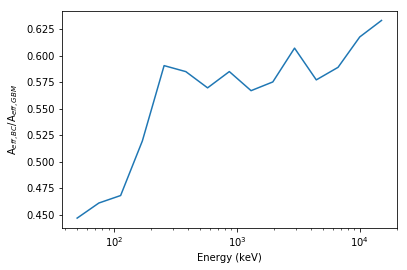

In [12]:
## grab short GRBs with peak spectral info & plot all of the Aeff curves
w=np.where((bcaeffs['diameter']==90) & (bcaeffs['height']==19) )
print bcaeffs[w]
bcaeffs=bcaeffs[w]

bceng=bcaeffs['keV']
#bcengdiff=bceng[1:]-bceng[0:-1]
#w=np.where(bcengdiff<0)[0]
#nsims=len(w)
#w=np.append(-1,w)#,len(eng))
#for i in range(nsims):
plot.plot(bcaeffs['keV'],bcaeffs['aeff'])
plot.xscale('log')
plot.yscale('log')
plot.xlabel('Energy (keV)')
plot.ylabel(r'Effective Area (cm$^2$)')
plot.plot(aeff_gbm['energy'],aeff_gbm['aeff'])
i=0
gbmae=loginterpol(aeff_gbm['energy'],aeff_gbm['aeff'],bceng)#[w[i]+1:w[i+1]+1])
plot.plot(bceng,gbmae)

plot.show()

plot.plot(bcaeffs['keV'],bcaeffs['aeff']/gbmae)
plot.xlabel('Energy (keV)')
plot.ylabel(r'A$_{eff,BC}$/A$_{eff,GBM}$')
#print(loginterpol(bcaeffs['keV'],bcaeffs['aeff']/gbmae,100.))
print(loginterpol(bcaeffs['keV'],bcaeffs['aeff']*0.78,50.))
print(loginterpol(bcaeffs['keV'],bcaeffs['aeff']*0.78,100.))
print(loginterpol(bcaeffs['keV'],bcaeffs['aeff']*0.78,1000.))
plot.xscale('log')

plot.show()

In [13]:
#w=np.where((bcaeffs['diameter']==90) & (bcaeffs['height']==19) )
print bcaeffs#[w]
BCaeffs=bcaeffs#[w]
#BCaeffs['aeff_eres_modfrac']=bcaeffs['aeff_eres_modfrac']*0.8
print float(BCaeffs['aeff_eres_modfrac'][2])/float(gbmae[2])
print loginterpol(BCaeffs['keV'],BCaeffs['aeff_eres_modfrac'],100.)
BCPaeff_factor=300./60.
# BCPaeffs=BCaeffs
# BCPaeffs['aeff']=BCPaeff_factor*BCPaeffs['aeff']
# BCPaeffs['aeff_eres']=BCPaeff_factor*BCPaeffs['aeff_eres']
# BCPaeffs['aeff_eres_modfrac']=BCPaeff_factor*BCPaeffs['aeff_eres_modfrac']

diameter height  az  ze   keV     aeff  aeff_eres aeff_eres_modfrac
-------- ------ --- --- ------- ------- --------- -----------------
    90.0   19.0 0.0 0.0    50.0 56.0057     47.28           54.9864
    90.0   19.0 0.0 0.0 75.1462 60.1213   54.4458           58.8948
    90.0   19.0 0.0 0.0 112.939 61.7605    57.709           60.0127
    90.0   19.0 0.0 0.0 169.739 61.7576    57.484           59.5096
    90.0   19.0 0.0 0.0 255.105 54.1984   46.5997           47.9276
    90.0   19.0 0.0 0.0 383.404 42.0248   28.8543           29.4006
    90.0   19.0 0.0 0.0 576.227 33.3321   16.7727            17.036
    90.0   19.0 0.0 0.0 866.025 27.8825   10.3667           20.7725
    90.0   19.0 0.0 0.0 1301.57 22.6889   6.15776           12.3291
    90.0   19.0 0.0 0.0 1956.16 19.9883   4.07161           8.16321
    90.0   19.0 0.0 0.0 2939.97 18.7626   2.57235           5.15783
    90.0   19.0 0.0 0.0 4418.55 18.1448   1.48243           2.97575
    90.0   19.0 0.0 0.0 6640.74 18.8384  0.83077

In [14]:
## grab energies from those curves and create an array of the energies
#E=np.array(bceng[w[i]+1:w[i+1]+1])
#print(E)

In [15]:
#Integrating the best fit spectrum for each GRB in the energy range of 50-300 KeV to get max. observed photon flux. 
#Doing the same but also folding in the effective area in order to get count rate.
#This will give us the photon flux in units of ph/cm^2/s. 
mo=gbmbursts['PFLX_BEST_FITTING_MODEL'][s]
bcpf=np.zeros(len(s)) 
bcppf=np.zeros(len(s)) 
pf=np.zeros(len(s))
gbmcr=np.zeros(len(s))
bccr=np.zeros(len(s))
bcpcr=np.zeros(len(s))
#pflx_duration=np.zeros(len(s))
outE=np.logspace(np.log10(50),np.log10(300),100) # returns numbers spaced evenly on a log scale
nsims=1
for i in range(len(s)):
    for j in range(nsims):
#        E=np.array(bceng[w[j]+1:w[j+1]+1])
#        AeffBC=loginterpol(E,bcaeffs['aeff'][w[j]+1:w[j+1]+1],outE)
        E=np.array(BCaeffs['keV'])
        AeffBC=loginterpol(E,BCaeffs['aeff_eres_modfrac'],outE)
#        AeffBCP=loginterpol(E,BCPaeffs['aeff_eres_modfrac'],outE)
        AeffBCP=AeffBC*BCPaeff_factor
        AeffGBM=loginterpol(aeff_gbm['energy'],aeff_gbm['aeff'],outE) #eng[w[j]+1:w[j+1]+1])       
        Aratio=(AeffBC/AeffGBM)
        Aratiop=Aratio*BCPaeff_factor
    
        # this should give us an array of the maximum observed photon flux for GBM
        if mo[i]=='PFLX_PLAW':
            gbmcr[i]=np.trapz(gbmbursts['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs.pl(outE,gbmbursts['PFLX_PLAW_INDEX'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbmbursts['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs.pl(outE,gbmbursts['PFLX_PLAW_INDEX'][s[i]]),outE)
            bccr[i]=np.trapz(gbmbursts['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs.pl(outE,gbmbursts['PFLX_PLAW_INDEX'][s[i]])*AeffGBM*Aratio,outE)
            bcpf[i]=np.trapz(gbmbursts['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs.pl(outE,gbmbursts['PFLX_PLAW_INDEX'][s[i]]),outE)
            bcpcr[i]=np.trapz(gbmbursts['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs.pl(outE,gbmbursts['PFLX_PLAW_INDEX'][s[i]])*AeffGBM*Aratiop,outE)
            bcppf[i]=np.trapz(gbmbursts['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs.pl(outE,gbmbursts['PFLX_PLAW_INDEX'][s[i]]),outE)
    
        if mo[i]=='PFLX_COMP':
            gbmcr[i]=np.trapz(gbmbursts['PFLX_COMP_AMPL'][s[i]]*grb_catalogs.comp(outE,gbmbursts['PFLX_COMP_INDEX'][s[i]],gbmbursts['PFLX_COMP_EPEAK'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbmbursts['PFLX_COMP_AMPL'][s[i]]*grb_catalogs.comp(outE,gbmbursts['PFLX_COMP_INDEX'][s[i]],gbmbursts['PFLX_COMP_EPEAK'][s[i]]),outE)
            bccr[i]=np.trapz(gbmbursts['PFLX_COMP_AMPL'][s[i]]*grb_catalogs.comp(outE,gbmbursts['PFLX_COMP_INDEX'][s[i]],gbmbursts['PFLX_COMP_EPEAK'][s[i]])*AeffGBM*Aratio,outE)
            bcpf[i]=np.trapz(gbmbursts['PFLX_COMP_AMPL'][s[i]]*grb_catalogs.comp(outE,gbmbursts['PFLX_COMP_INDEX'][s[i]],gbmbursts['PFLX_COMP_EPEAK'][s[i]]),outE)
            bcpcr[i]=np.trapz(gbmbursts['PFLX_COMP_AMPL'][s[i]]*grb_catalogs.comp(outE,gbmbursts['PFLX_COMP_INDEX'][s[i]],gbmbursts['PFLX_COMP_EPEAK'][s[i]])*AeffGBM*Aratiop,outE)
            bcppf[i]=np.trapz(gbmbursts['PFLX_COMP_AMPL'][s[i]]*grb_catalogs.comp(outE,gbmbursts['PFLX_COMP_INDEX'][s[i]],gbmbursts['PFLX_COMP_EPEAK'][s[i]]),outE)
    
        if mo[i]=='PFLX_BAND':
            gbmcr[i]=np.trapz(gbmbursts['PFLX_BAND_AMPL'][s[i]]*grb_catalogs.band(outE,gbmbursts['PFLX_BAND_ALPHA'][s[i]],gbmbursts['PFLX_BAND_EPEAK'][s[i]],gbmbursts['PFLX_BAND_BETA'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbmbursts['PFLX_BAND_AMPL'][s[i]]*grb_catalogs.band(outE,gbmbursts['PFLX_BAND_ALPHA'][s[i]],gbmbursts['PFLX_BAND_EPEAK'][s[i]],gbmbursts['PFLX_BAND_BETA'][s[i]]),outE)
            bccr[i]=np.trapz(gbmbursts['PFLX_BAND_AMPL'][s[i]]*grb_catalogs.band(outE,gbmbursts['PFLX_BAND_ALPHA'][s[i]],gbmbursts['PFLX_BAND_EPEAK'][s[i]],gbmbursts['PFLX_BAND_BETA'][s[i]])*AeffGBM*Aratio,outE)
            bcpf[i]=np.trapz(gbmbursts['PFLX_BAND_AMPL'][s[i]]*grb_catalogs.band(outE,gbmbursts['PFLX_BAND_ALPHA'][s[i]],gbmbursts['PFLX_BAND_EPEAK'][s[i]],gbmbursts['PFLX_BAND_BETA'][s[i]]),outE)
            bcpcr[i]=np.trapz(gbmbursts['PFLX_BAND_AMPL'][s[i]]*grb_catalogs.band(outE,gbmbursts['PFLX_BAND_ALPHA'][s[i]],gbmbursts['PFLX_BAND_EPEAK'][s[i]],gbmbursts['PFLX_BAND_BETA'][s[i]])*AeffGBM*Aratiop,outE)
            bcppf[i]=np.trapz(gbmbursts['PFLX_BAND_AMPL'][s[i]]*grb_catalogs.band(outE,gbmbursts['PFLX_BAND_ALPHA'][s[i]],gbmbursts['PFLX_BAND_EPEAK'][s[i]],gbmbursts['PFLX_BAND_BETA'][s[i]]),outE)

        if mo[i]=='PFLX_SBPL':
            gbmcr[i]=np.trapz(gbmbursts['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs.sbpl(outE,gbmbursts['PFLX_SBPL_INDX1'][s[i]],gbmbursts['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbmbursts['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs.sbpl(outE,gbmbursts['PFLX_SBPL_INDX1'][s[i]],gbmbursts['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]]),outE)
            bccr[i]=np.trapz(gbmbursts['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs.sbpl(outE,gbmbursts['PFLX_SBPL_INDX1'][s[i]],gbmbursts['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]])*AeffGBM*Aratio,outE)
            bcpf[i]=np.trapz(gbmbursts['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs.sbpl(outE,gbmbursts['PFLX_SBPL_INDX1'][s[i]],gbmbursts['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]]),outE)
            bcpcr[i]=np.trapz(gbmbursts['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs.sbpl(outE,gbmbursts['PFLX_SBPL_INDX1'][s[i]],gbmbursts['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]])*AeffGBM*Aratiop,outE)
            bcppf[i]=np.trapz(gbmbursts['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs.sbpl(outE,gbmbursts['PFLX_SBPL_INDX1'][s[i]],gbmbursts['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]]),outE)
#        pflx_duration[i]=gbmbursts['PFLX_SPECTRUM_STOP'][s[i]]-gbmbursts['PFLX_SPECTRUM_START'][s[i]]


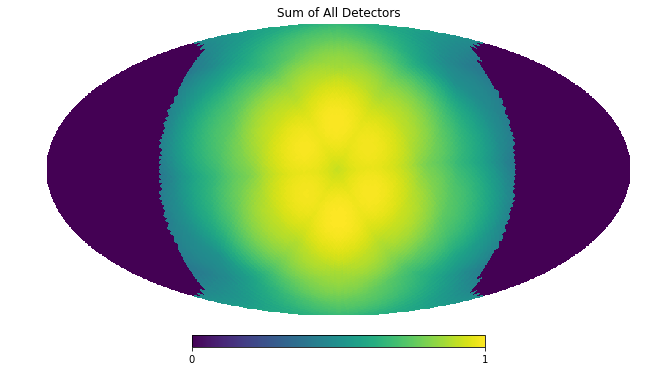

In [16]:
## setup GBM
gbm_pointings = {'01': ('45:54:0','20:36:0'),
            '02': ('45:6:0','45:18:0'),
            '03': ('58:24:0','90:12:0'),
            '04': ('314:54:0','45:12:0'),
            '05': ('303:12:0','90:18:0'),
            '06': ('3:24:0','89:48:0'),
            '07': ('224:54:0','20:24:0'),
            '08': ('224:36:0','46:12:0'),
            '09': ('236:36:0','90:0:0'),
            '10': ('135:12:0','45:36:0'),
            '11': ('123:42:0','90:24:0'),
            '12': ('183:42:0','90:18:0')}

npointings=len(gbm_pointings)
fermi = Spacecraft(gbm_pointings,lat='00:00:00',lon='260:00:00')
NSIDE = 32
exposure_positions_hp = np.arange(hp.nside2npix(NSIDE))
exposure_positions_pix = hp.pix2ang(NSIDE, exposure_positions_hp, lonlat=True)
exposure_positions = np.vstack(exposure_positions_pix)
gbm_exposures = np.array([[ detector.exposure(position[0],position[1], alt=-20.,index=1.0) for position in exposure_positions.T] 
                      for detector in fermi.detectors])

plot.figure(figsize=(20,npointings))
for i in range(npointings):
    hp.mollview(gbm_exposures[i]/max(gbm_exposures[i]), max=1,title='Detector '+gbm_pointings.keys()[i],\
                sub = [int(npointings/3.),3,int(str(i+1))])
exps=gbm_exposures.sum(axis=0)
fs=(exps-min(exps))/max(exps)
hp.mollview(fs,title='Sum of All Detectors')

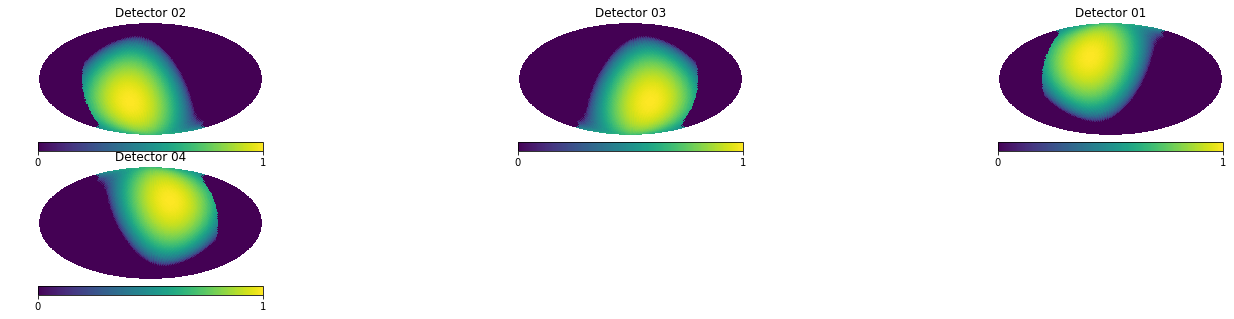

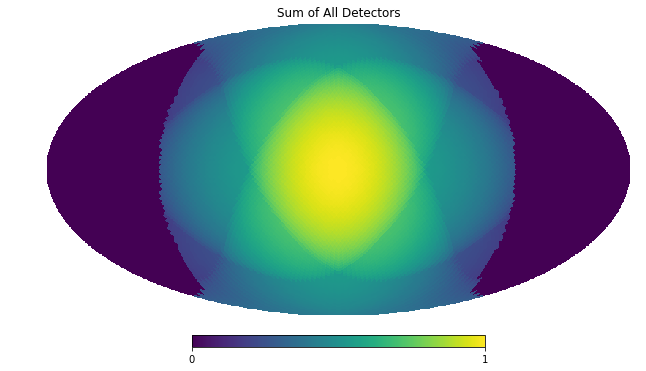

In [17]:
## setup BurstCube
pointings = {'01': ('45:0:0','45:0:0'),
           '02': ('135:0:0','45:0:0'),
           '03': ('225:0:0','45:0:0'),
           '04': ('315:0:0','45:0:0')}

npointings=len(pointings)
burstcube = Spacecraft(pointings,lat='00:00:00',lon='260:00:00')
NSIDE = 32
exposure_positions_hp = np.arange(hp.nside2npix(NSIDE))
exposure_positions_pix = hp.pix2ang(NSIDE, exposure_positions_hp, lonlat=True)
exposure_positions = np.vstack(exposure_positions_pix)
exposures = np.array([[ detector.exposure(position[0],position[1], alt=-20.,index=0.55) for position in exposure_positions.T] 
                      for detector in burstcube.detectors])

plot.figure(figsize=(20,npointings))
for i in range(npointings):
    hp.mollview(exposures[i]/max(exposures[i]), max=1,title='Detector '+pointings.keys()[i],\
                sub = [np.round(npointings/3.+0.5),3,int(str(i+1))])
exps=exposures.sum(axis=0)
fs=(exps-min(exps))/max(exps)
hp.mollview(fs,title='Sum of All Detectors')

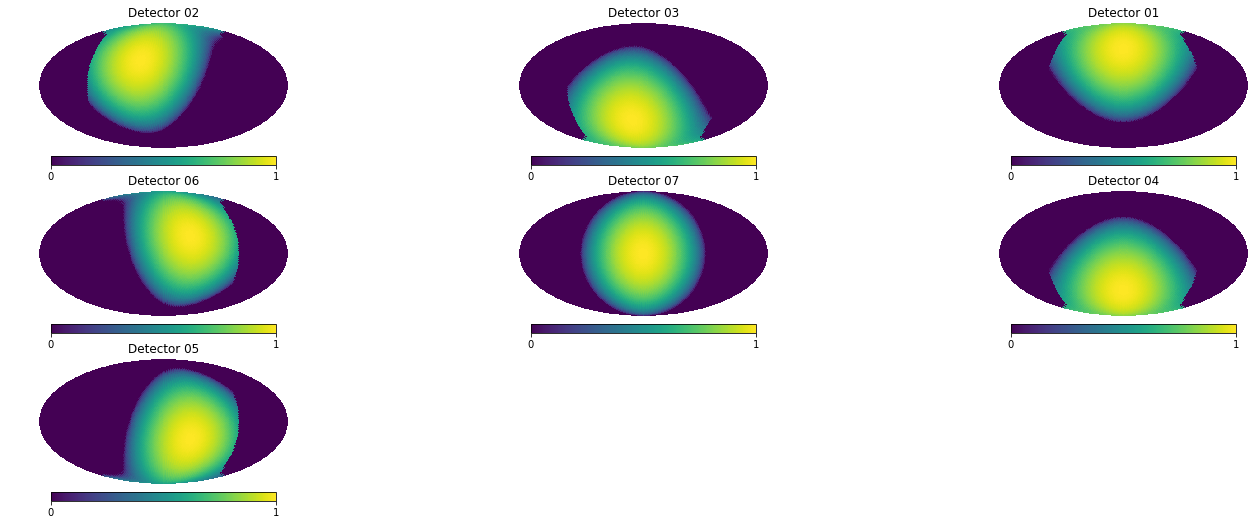

In [18]:
## setup BurstCube Prime
bcp_pointings = {'01': ('0:0:0','45:0:0'),
           '02': ('45:0:0','45:0:0'),
           '03': ('160:0:0','45:0:0'),
           '04': ('180:0:0','45:0:0'),
           '05': ('240:0:0','45:0:0'),
           '06': ('300:0:0','45:0:0'),
           '07': ('0:0:0','0:0:0')}

npointings=len(bcp_pointings)
bcp = Spacecraft(bcp_pointings,lat='00:00:00',lon='260:00:00')
NSIDE = 32
exposure_positions_hp = np.arange(hp.nside2npix(NSIDE))
exposure_positions_pix = hp.pix2ang(NSIDE, exposure_positions_hp, lonlat=True)
exposure_positions = np.vstack(exposure_positions_pix)
bcp_exposures = np.array([[ detector.exposure(position[0],position[1], alt=-20.,index=0.55) for position in exposure_positions.T] 
                      for detector in bcp.detectors])

plot.figure(figsize=(20,npointings))
for i in range(npointings):
    hp.mollview(bcp_exposures[i]/max(bcp_exposures[i]), max=1,title='Detector '+bcp_pointings.keys()[i],\
                sub = [np.round(npointings/3.+0.5),3,int(str(i+1))])
exps=bcp_exposures.sum(axis=0)
fs=(exps-min(exps))/max(exps)
hp.mollview(fs,title='Sum of All Detectors')

In [19]:
# now that GBM and BurstCube's pointings are set up we will throw GRBs at it and determine the exposure for each GRB. 
#generate GRBs and throw them at GBM

def throw_grbs(fermi,burstcube,bcp):
    
    nsims=int(np.round(len(simgbmpfsample))) 
    ra,dec=random_sky(nsims)
    ra=np.array(ra)-180
    dec=np.array(dec)
     

    #GBM and BurstCube exposures for each random GRB.
    randgbmexposures = np.array([[detector.exposure(ra[i],dec[i], alt=-20.,index=1.0) for i in range(nsims)] for detector in fermi.detectors])
    randbcexposures = np.array([[detector.exposure(ra[i],dec[i], alt=-20.,index=0.55) for i in range(nsims)] for detector in burstcube.detectors])
    randbcpexposures = np.array([[detector.exposure(ra[i],dec[i], alt=-20.,index=1.0) for i in range(nsims)] for detector in bcp.detectors])
    
    #Order randgbmexposures into descending order
    for column in randgbmexposures.T:
        newrandgbm = -np.sort(-randgbmexposures.T) 
    gbmexposures = np.transpose(newrandgbm)
    
    for col in randbcexposures.T:
        newrandbc = -np.sort(-randbcexposures.T) 
    bcexposures = np.transpose(newrandbc)

    for col in randbcpexposures.T:
        newrandbcp = -np.sort(-randbcpexposures.T) 
    bcpexposures = np.transpose(newrandbcp)
    
    #Select the second highest exposure value. 
    #We will use this to ensure the second highest exposure detector has a sig >4.5
    secondhighestgbm = gbmexposures[1,:]
    secondhighestbc = bcexposures[1,:]
    secondhighestbcp = bcpexposures[1,:]    
        
    return gbmexposures, bcexposures, bcpexposures, secondhighestgbm, secondhighestbc, secondhighestbcp, randgbmexposures, randbcexposures, randbcpexposures

In [20]:
#plot Batse[64] against pf to see if they are the same
flux=gbmbursts['FLUX_BATSE_64'][s]
#print pf.shape[0]

# plot.figure()
# plot.hist(np.log10(flux),bins=50)
# #plot.xscale('log')
# x=np.linspace(-2,3,500)
# x10=10**x
# p0=50.*x10**(-0.5)

# plot.plot(x,p0)
# plot.yscale('log')
# plot.ylim([1,100])
# plot.xlim([-1,2.5])
# plot.show()

# p=p0/sum(p0)
# r=np.random.choice(500,5000, replace=True, p=p)-200.#-100.
# r=r/100.
# print min(r),max(r)
# plot.hist(r,30)
# #plot.xscale('log')
# plot.plot(x,p0)
# plot.yscale('log')
# plot.ylim([1,1e2])
# plot.xlim([-1,2.5])
# print len(r)
# pr=10.**r

In [21]:
#define probability
p = np.array((np.arange(pf.shape[0])+1)**(-0.4))
p=p/sum(p)
# #randomly sample from the array of photon fluxes found above using our probability function found above so we draw more low flux bursts
# #creating our "intrinsic" sample
r=np.random.choice(pf.shape[0],1500, replace=True, p=p)
so=np.argsort(pf)
r=so[r]

simgbmpfsample = np.array(pf[r])
simgbmcr = np.array(gbmcr[r])
simbcpfsample = np.array(bcpf[r])
simbccr = np.array(bccr[r])
simbcppfsample = np.array(bcppf[r])
simbcpcr = np.array(bcpcr[r])
# plot.hist(np.log10(pr/pf[r]),100)

# simgbmpfsample=pf[r]*pr/pf[r]
# simgbmcr=gbmcr[r]*pr/pf[r]
# simbcpfsample=bcpf[r]*pr/pf[r]
# simbccr=bccr[r]*pr/pf[r]
# simbcppfsample=bcppf[r]*pr/pf[r]
# simbcpcr=bcpcr[r]*pr/pf[r]

(0.0018056021890154015, 0.01856529916237574)


Text(0.5,0,'Peak Flux (ph/cm2/s)')

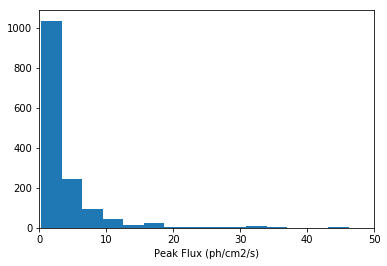

In [22]:
#examining our probability distribution to be sure it is performing the eay we intend it to
print(min(p),max(p))
#plot.hist(p,bins=50)
plot.plot((np.arange(pf.shape[0])+1),p)
#plot.xscale('log')
#plot.yscale('log')

plot.figure()
plot.hist(pf[r],bins=50)
plot.xlim(0,50)
plot.xlabel('Peak Flux (ph/cm2/s)')
#plot.xscale('log')
#plot.yscale('log')

In [23]:
#define the peak flux interval using the trigger catalog
msinterval = trigbursts['Trigger_Timescale'][s] 
interval = msinterval/1000.
print interval

[0.064 0.064 0.256 0.064 0.032 0.512 0.016 0.064 0.064 0.064 0.064 0.032
 0.032 0.064 0.128 0.128 0.256 0.128 0.256 0.064 0.128 0.256 0.032 0.032
 0.016 0.064 0.128 0.064 0.128 0.128 0.032 0.128 0.064 0.064 0.064 0.032
 0.016 0.016 0.032 0.128 0.064 0.256 0.064 0.064 0.064 0.016 0.128 1.024
 0.064 0.064 0.512 0.064 0.256 0.016 0.016 0.016 0.016 0.064 0.064 1.024
 0.064 0.016 0.016 0.016 0.256 0.064 0.064 0.032 1.024 0.256 0.256 0.064
 0.064 0.064 0.064 0.064 0.064 0.256 0.064 0.128 0.016 0.128 0.128 0.064
 0.064 0.064 0.256 0.064 0.064 0.064 0.064 0.256 0.128 0.032 0.016 0.064
 0.016 0.128 0.016 0.256 0.032 0.128 0.512 0.064 0.016 0.064 0.256 0.128
 0.256 0.512 0.256 0.512 1.024 1.024 4.096 2.048 0.128 1.024 0.016 0.512
 1.024 4.096 0.064 0.512 0.064 0.016 1.024 1.024 0.256 2.048 2.048 2.048
 0.032 0.512 2.048 1.024 0.256 0.512 0.064 1.024 2.048 2.048 0.064 0.512
 4.096 0.256 0.256 0.256 0.256 0.128 1.024 0.256 4.096 2.048 1.024 0.256
 0.512 0.064 1.024 0.256 0.256 1.024 0.512 1.024 0.

In [24]:
#flux=simpf this is in ph/sec
flux=simgbmpfsample
#minflux=min(flux)
#maxflux=max(flux)
gbmexposures, bcexposures, bcpexposures, secondhighestgbm, secondhighestbc, secondhighestbcp, randgbmexposures, randbcexposures, randbcpexposures = throw_grbs(fermi, burstcube, bcp)



In [25]:
#Solve for the number of detected counts which will equal our source photons
sourcegbm = simgbmcr*secondhighestgbm*interval[r]
sourcebc = simbccr*secondhighestbc*interval[r]
sourcebcp = simbcpcr*secondhighestbcp*interval[r]

In [26]:
#Assuming a background count rate. units: cts/s
bckgrd=300.

#scale the background count rate for the second highest detector
scaledgbmbckgrd = bckgrd*secondhighestgbm*interval[r]
scaledbcbckgrd = bckgrd*secondhighestbc*interval[r]*0.588
scaledbcpbckgrd = bckgrd*secondhighestbcp*interval[r]*5.

In [27]:
#creating an array of zeros that I can manipulate to create an array of detected GRBs
detectgbm = np.zeros(len(simgbmpfsample))
detectbc = np.zeros(len(simbcpfsample))
detectbcp = np.zeros(len(simbcppfsample))

#calculate the significance of the second highest exposure detector. If the significance is greater than 4.5 sigma than the burst is detectable.
for u in range(len(simgbmpfsample)):
    sig = sourcegbm[u] / (np.sqrt(sourcegbm[u] + scaledgbmbckgrd[u]))
    if sig > 4.5:
        detectgbm[u] = 1.0
    else:
        detectgbm[u] = 0.0

for j in range(len(simbcpfsample)):
    sig = sourcebc[j] / (np.sqrt(sourcebc[j] + scaledbcbckgrd[j]))
    if sig > 4.5:
        detectbc[j] = 1.0
    else:
        detectbc[j] = 0.0

for j in range(len(simbcppfsample)):
    sig = sourcebcp[j] / (np.sqrt(sourcebcp[j] + scaledbcpbckgrd[j]))
    if sig > 4.5:
        detectbcp[j] = 1.0
    else:
        detectbcp[j] = 0.0


/Users/jracusin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/jracusin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/jracusin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


/Users/jracusin/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


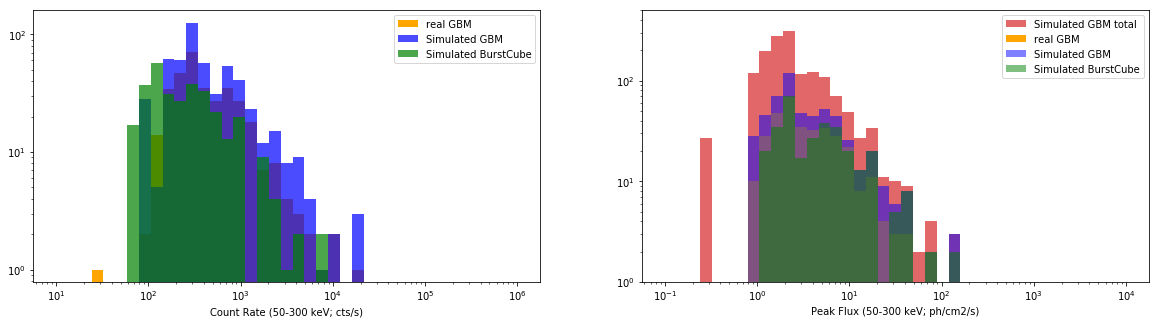

In [28]:
#Creating plot of peak flux versus counts for real and simulated GBM
w=np.where(pf>0)[0]
wg = np.where(simgbmcr*detectgbm>0.)[0]
wbc = np.where(simbccr*detectbc>0.)[0]
wbcp = np.where(simbcpcr*detectbcp>0.)[0]

fig=plot.figure(figsize=(20,5))
plot.subplot(1,2,1)
plot.hist(gbmcr[w],label='real GBM',bins=np.logspace(1,6,40),color='orange')
plot.hist(simgbmcr[wg],label='Simulated GBM',bins=np.logspace(1,6,40),alpha=0.7,color='blue')
plot.hist(simbccr[wbc],label='Simulated BurstCube',bins=np.logspace(1,6,40),alpha=0.7,color='green')
plot.xlabel('Count Rate (50-300 keV; cts/s)')
plot.xscale('log')
plot.yscale('log')

plot.legend()
plot.subplot(1,2,2)
#plot.hist(flux,label='All',bins=np.logspace(-1,2,40),color='green')
#pf has been gathered from the GBM catalog
#plot.hist(pr,bins=np.logspace(-1,4,40),alpha=0.5,color='C3')
#plot.hist(simbcppfsample[wbcp],label='Simulated BurstCube Prime',bins=np.logspace(-1,4,40),alpha=0.7,color='C4')
plot.hist(simgbmpfsample,label='Simulated GBM total',bins=np.logspace(-1,4,40),alpha=0.7,color='C3')
plot.hist(pf[w],label='real GBM',bins=np.logspace(-1,4,40),color='orange')
# this is the simulated GBM
plot.hist(simgbmpfsample[wg],label='Simulated GBM',bins=np.logspace(-1,4,40),alpha=0.5,color='blue')
plot.hist(simbcpfsample[wbc],label='Simulated BurstCube',bins=np.logspace(-1,4,40),alpha=0.5,color='green')
plot.xlabel('Peak Flux (50-300 keV; ph/cm2/s)')
#plot.hist(flux[w],label='BC',bins=np.logspace(-1,2,40),alpha=0.7,color='red')
plot.xscale('log')
plot.yscale('log')
plot.ylim([0,500])
plot.legend()

plot.show()

In [29]:
#solve for the detection fraction of BurstCube and Simulated GBM
detgbm = np.where(detectgbm == 1)[0]
ratiogbm = len(detgbm)*1. / len(detectgbm)
print(ratiogbm)

detbc = np.where(detectbc == 1)[0]
ratiobc = len(detbc)*1. / len(detectbc)
print(ratiobc)

detbcp = np.where(detectbcp == 1)[0]
ratiobcp = len(detbcp)*1. / len(detectbcp)
print(ratiobcp)

print('fraction of GBM sGRBs BC will detect = %0.2f'%(ratiobc/ratiogbm))
#number of bursts BurstCube will see a year
bcbursts = ratiobc/ratiogbm *40.
print('bc rate = %.2f'%bcbursts+' sGRBs/yr')

#print(ratiobcp/ratiogbm)
#number of bursts BurstCube-Prime will see a year
bcpbursts = ratiobcp/ratiogbm *40.
print('bcp rate = %.2f'%bcpbursts+' sGRBs/yr')

0.360666666667
0.208666666667
0.375333333333
fraction of GBM sGRBs BC will detect = 0.58
bc rate = 23.14 sGRBs/yr
bcp rate = 41.63 sGRBs/yr


In [30]:
### Duty Cycle to detect 20 sGRBs/yr
gbmduty=0.85
duty=20./(bcbursts/gbmduty)
print("duty cycle to detect 20 sGRBs/yr = %.2f" %duty)
duty=10./(bcbursts/gbmduty)
print("duty cycle to detect 10 sGRBs/yr = %.2f" %duty)

duty cycle to detect 20 sGRBs/yr = 0.73
duty cycle to detect 10 sGRBs/yr = 0.37


flux limit to detect 10 sGRBs/yr = 5.00 ph/cm2/s
flux limit to detect 20 sGRBs/yr = 1.71 ph/cm2/s
expected minimum flux = 1.18 ph/cm2/s
expected maximum flux = 153.36 ph/cm2/s
expected 90% maximum flux = 16.20 ph/cm2/s
expected 95% maximum flux = 31.55 ph/cm2/s


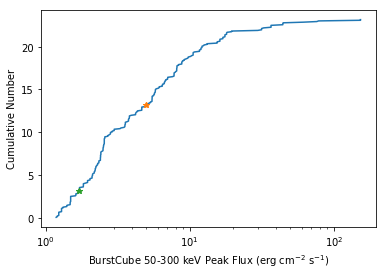

In [31]:
### Min sensitivity to detect 10 per year
nbursts10=bcbursts-10.
nbursts20=bcbursts-20.
so=np.argsort(simbcpfsample[wbc])
#hist,bin_edges=np.histogram(simbcpfsample[wbc],bins=np.logspace(-3,3,100))
#print hist
#plot.hist(bin_edges,np.cumsum(hist))
c=np.cumsum(np.ones(len(wbc)))/len(wbc)*bcbursts
#c=np.cumsum(simbcpfsample[wbc[so]])#/interval[r[wbc[so]]])
plot.plot(simbcpfsample[wbc[so]],c)
plot.xlabel(r'BurstCube 50-300 keV Peak Flux (erg cm$^{-2}$ s$^{-1}$)')
plot.ylabel('Cumulative Number')
plot.xscale('log')
#plot.yscale('log')
fluxlim10=loginterpol(c,simbcpfsample[wbc[so]],nbursts10)
fluxlim20=loginterpol(c,simbcpfsample[wbc[so]],nbursts20)
plot.plot([fluxlim10,fluxlim10],[nbursts10,nbursts10],marker='*')
plot.plot([fluxlim20,fluxlim20],[nbursts20,nbursts20],marker='*')
print("flux limit to detect 10 sGRBs/yr = %.2f"%fluxlim10+' ph/cm2/s')
print("flux limit to detect 20 sGRBs/yr = %.2f"%fluxlim20+' ph/cm2/s')
#print("%.2f"%max(c) )
print('expected minimum flux = '+"%.2f"%min(simbcpfsample[wbc[so]])+' ph/cm2/s')
print('expected maximum flux = '+"%.2f"%max(simbcpfsample[wbc[so]])+' ph/cm2/s')
print('expected 90% maximum flux = '+"%.2f"%simbcpfsample[wbc[so[int(0.9*len(so))]]]+' ph/cm2/s')
print('expected 95% maximum flux = '+"%.2f"%simbcpfsample[wbc[so[int(0.95*len(so))]]]+' ph/cm2/s')

In [32]:
## FoV - adjusted exposure alt until total reached 20
BCFoVrad = 90-0. # deg radius
BCFoV=(1-np.cos(np.radians(BCFoVrad)))/2.*4.*np.pi
print("%.1f" % BCFoV+' ster')

6.3 ster


In [33]:
## max distance of GW170817
mpc2cm=3.086e24
fgw=3.7 # ph/cm2/s
fmax=min(simgbmpfsample[wg])
dgw=42.9*mpc2cm
dmax=np.sqrt(fgw*dgw**2/fmax)
f=80.*mpc2cm/dmax
print("%.2f" % (dmax/mpc2cm*f)+' Mpc - distance GBM for GW170817')

fmax=min(simbcpfsample[wbc])
dmax=np.sqrt(fgw*dgw**2/fmax)
print("%.2f" % (dmax/mpc2cm*f)+' Mpc - distance BC for GW170817')

fmax=min(simbcppfsample[wbcp])/BCPaeff_factor
dmax=np.sqrt(fgw*dgw**2/fmax)
print("%.2f" % (dmax/mpc2cm*f)+' Mpc - distance BCP for GW170817')

80.00 Mpc - distance GBM for GW170817
66.22 Mpc - distance BC for GW170817
178.89 Mpc - distance BCP for GW170817


In [34]:
### mission lifetime to detect 10 sGRBs
print("%.1f" % (10./bcbursts*12.)+' months')

5.2 months


/Users/jracusin/anaconda/lib/python2.7/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


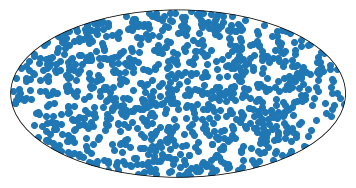

In [35]:
nsims=1000
ra,dec=random_sky(nsims)
ra=np.array(ra)-180
dec=np.array(dec)
ax = plot.subplot(111, projection = 'mollweide')
plot.scatter(np.radians(ra),np.radians(dec),marker='o')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plot.show()

In [36]:
trigfit=fits.open(myBCgitdir+'gbmtrigcat.fits')
trig=trigfit[1].data

print trig.columns

ColDefs(
    name = 'VERSION'; format = 'A7'; start = 1
    name = 'TRIGGER_NAME'; format = 'A12'; start = 9
    name = 'NAME'; format = 'A14'; start = 22
    name = 'RA'; format = 'F8.0'; unit = 'DEGREE'; disp = 'F8.4'; start = 37
    name = 'DEC'; format = 'F8.0'; unit = 'DEGREE'; disp = 'F8.4'; start = 46
    name = 'LII'; format = 'F8.0'; unit = 'DEGREE'; disp = 'F8.4'; start = 55
    name = 'BII'; format = 'F8.0'; unit = 'DEGREE'; disp = 'F8.4'; start = 64
    name = 'ERROR_RADIUS'; format = 'F12.0'; unit = 'DEGREE'; disp = 'F12.4'; start = 73
    name = 'TIME'; format = 'F15.0'; unit = 'MJD'; disp = 'F15.7'; start = 86
    name = 'END_TIME'; format = 'F15.0'; unit = 'MJD'; disp = 'F15.7'; start = 102
    name = 'TRIGGER_TIME'; format = 'F15.0'; unit = 'MJD'; disp = 'F15.7'; start = 118
    name = 'TRIGGER_TYPE'; format = 'A12'; start = 134
    name = 'RELIABILITY'; format = 'F11.0'; disp = 'F11.4'; start = 147
    name = 'TRIGGER_TIMESCALE'; format = 'I17'; unit = 'MS'; start = 1

plot.figure()
plot.hist(trig['time'])
plot.show()
print len(trig)
print max(trig['time'])-min(trig['time'])
6551/3727

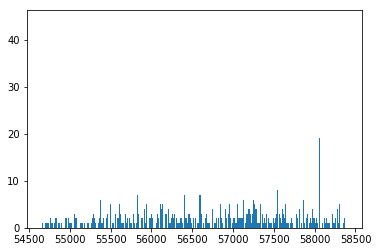

6551
3727.906338274006
1.75771397907


In [37]:
plot.figure() 
h=plot.hist(trig['time'],3727) 
plot.show() 
print len(trig) 
print max(trig['time'])-min(trig['time']) 
print 6551/3727.

44.0


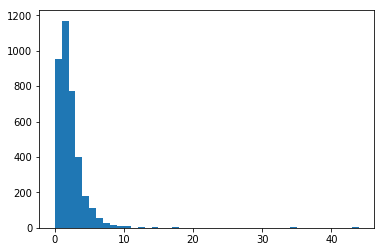

1.0
4.0


In [38]:
x=h[0]
y=h[1]
print max(x)
h2=plot.hist(x,44)
plot.show()
print np.median(x)
print x[np.argsort(x)[3354]]

In [39]:
print min(pf[w])

0.2571156550207681
